<h3>TODO</h3> 
Fill in any place that says <code># YOUR CODE HERE</code> (make sure to remove the line <code>raise NotImplementedError()</code>).

<h3>Suggestions</h3>

- To speed up your code, think about how certain operations can be done at the same time.
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- Double check your code does not have $\infty$-loops, these will crash the autograder.

<h3>Rules</h3>

- Blank cells in the notebook are hidden tests. **Do not delete, copy, paste, or alter these cells as this will cause the tests to fail automatically**.
- Do not create multiple python notebooks (.ipynb files).
- Do not import any new python packages (this may cause hidden tests to fail).
- Each cell must run for less than 5 minutes (there exists a solution with full marks).
- **Do not plagiarise!** We take violations of this very seriously. In previous years we have identified instances of plagiarism and reported them to the Senior Teaching & Learning Administrator.
- If you are happy with your current grade you do not need to resubmit, the most recent grade from the autograder will be your final grade.

---

In [ ]:
import numpy as np
np.random.seed(0)
from numpy.matlib import repmat
import sys
import time
import l2distance
from l2distance import l2distance
import visclassifier
import matplotlib
import matplotlib.pyplot as plt
import traceback

import pylab
from matplotlib.animation import FuncAnimation

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random

#%matplotlib widget
%matplotlib inline

<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. For this, we will be dipping into the shallow end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. This allows us to multiply/use torch parameter objects with our data directly. Pytorch tensors carry most of the same functionality as numpy arrays.

We will start with a simple example of PyTorch, where we use gradient descent to find the parameters of a simple linear regression problem.

In [2]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.normal(size=(num_samples, 1)) * 0.02
    test_noise = np.random.normal(size=(int(num_samples * 0.1), 1)) * 0.02
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [3]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

Now we will create our PyTorch model. PyTorch models inherit the class torch.nn.module, and you need to implement the function forward which is equivalent to a forward pass. Usually, you feed in batch of x samples as input and you get batch of outputs, but you could pass other parameters as well if needed. Every torch module will implement two functions. __init__ its constructor, and __forward__ which defines what happens when you call the module.

Note we define two fields of the <code>LinearRegressionModel</code>:
* <code>self.w</code>: The weight vector of the linear regression model. This is updated automatically by Pytorch in our training loop because we define it as a nn.Parameter (note requires_grad=True). Additionally <code>torch.randn(ndims, 1)</code> gives us an initialization for this weight vector.
* <code>self.b</code>: The bias of the linear regression model. This is also updated automatically by Pytorch in our training loop.

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self, dim):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

For this example we use our familiar mean-squared error loss.

In [5]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a generic training loop in Pytorch, this will be very useful for you in your assignment. We have supplied comments per line to help walk you through what each different part does.

In [6]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [7]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.3273194399606484
epoch 200 loss 0.24649507968758133
epoch 300 loss 0.2118068745291472
epoch 400 loss 0.18439650271778713
epoch 500 loss 0.16072583347479388
epoch 600 loss 0.14010910709987417
epoch 700 loss 0.12213841239668374
epoch 800 loss 0.10647296392225332
epoch 900 loss 0.0928170004835117
epoch 1000 loss 0.08091271654711119
epoch 1100 loss 0.07053541580826213
epoch 1200 loss 0.06148925609361831
epoch 1300 loss 0.053603438979284976
epoch 1400 loss 0.04672918135709931
epoch 1500 loss 0.0407367124638766
epoch 1600 loss 0.035512913292580855
epoch 1700 loss 0.030959186564518595
epoch 1800 loss 0.026989590175859102
epoch 1900 loss 0.02352916311130231
epoch 2000 loss 0.020512639583360515
avg test error 0.021842248793493203


Now, we have a trained model object that we can predict with by passing in input data via model.forward(x). Let's visualize how good of a fit our line is to the data!

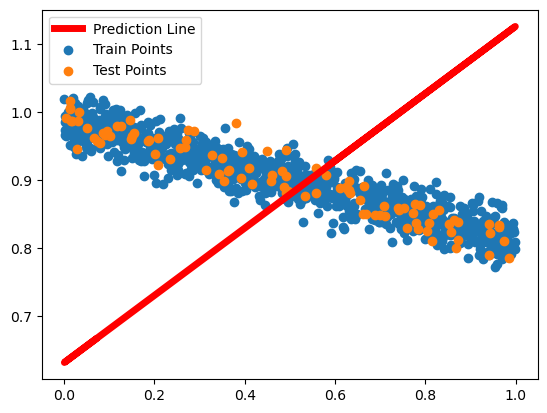

In [8]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

For the following assignment there are a bunch of PyTorch specfic functions that we believe will be very helpful for you. Those are:

* <code>torch.clamp(input, min=None, max=None, *, out=None) </code>: Clamps all elements in input into the range [min, max]

* <code>torch.sum(input, *, dtype=None) </code>: Returns the sum of all elements in the input tensor.

* <code>torch.mean(input, *, dtype=None)</code>: Returns the mean value of all elements in the input tensor.

* <code>torch.pow(input, exponent, *, out=None)</code>: Takes the power of each element in input with exponent and returns a tensor with the result.

* <code>torch.exp(input, *, out=None)</code>: Returns a new tensor with the exponential of the elements of the input tensor.

<h3> Linear classification</h3>

<p> The first part of the assignment is to implement a linear support vector machine. In order to do this, we are going to generate random data to classify:
</p>

In [9]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Note that we aren't doing linear programming, this is gradient descent optimization so the constraints are something we do not worry about.</p>

To warm up, implement <code>hinge_loss</code>, which calculates the loss described in $\sum_{i=1}^n \xi_i$. Working with torch tensors is a lot like working with numpy tensors, think about the best way to do tensor on tensor operations. <b>This method requires no loops</b>.

Hint: <code>torch.clamp</code> might be useful here

In [10]:
def hinge_loss(y_pred, y_true):
    # YOUR CODE HERE
    # This is the hinge loss of predictions versus labels - the label is already provided
    loss = torch.clamp( (1 - (y_pred * y_true)), 0)
    return torch.sum(loss)

In [11]:
#
# ----------- MY TEST CELL ----------------
#
import torch.nn as nn
import sklearn.metrics as sk
from l2distance import *

#
# my solution using numpy
#
def my_np_loss(y_pred, y_true):
    total_loss = 0
    for i in range(y_pred.shape[0]):
        res = 1 - (y_pred[i] * y_true[i]) 
        
        if (res > 0):
            loss = res
        else:
            loss = 0
        
        #print('label:', y_true[i], 'pred:', y_pred[i], 'res:', res, 'loss:', loss)
        total_loss += loss
    print('my_np total loss:', total_loss)


#
# solution I used at MITx
#
def pegasus_loss(y_pred, y_true):
    n = y_true.shape[0]
    #print('Pegasus with', n, 'predictions')
    
    total_loss = 0
    for i in range(n):
        z = y_true[i] * y_pred[i]
        if z>= 1:
            hinge_loss = 0
        else:
            hinge_loss = 1 - z
        total_loss += hinge_loss
    print('pegasus total loss:', total_loss)

#
# using pytorch
# 
def torch_hl(y_pred, y_true):
    torch_loss = nn.HingeEmbeddingLoss()
    py_loss = torch_loss(y_pred, y_true)    
    print('torch loss is:', py_loss, '\n')
    
torch_pred = torch.Tensor([0.97, 1.2, 0, -0.25, -0.88, -1.01, -0, 0.4])
torch_true = torch.Tensor([1,  1, 1, 1, -1, -1, -1, -1])
torch_loss = torch_hl(torch_pred, torch_true)    

#
# try the solution I wrote
#
cw2_loss = hinge_loss(torch_pred, torch_true)
print('cw2 loss:', cw2_loss)

# use stadard numpy
y_pred = np.array([0.97, 1.2, 0, -0.25, -0.88, -1.01, -0, 0.4])
y_true = np.array([1,  1, 1, 1, -1, -1, -1, -1])
my_loss = my_np_loss(y_pred, y_true)

# try MITx Pegasus
pegasus_loss(y_pred, y_true)

# check
#answer = .03 + 0 +1 +1.25 +0.12 + 0+ 1 +1.4
#print('\ncorrect:', answer)


# check L2 Sq Norm
print('\n L2 Sq Norm -----')
weights = torch.Tensor([[1],[-2], [3]])
weights_sq = torch.pow(weights, 2)
w_sq_l2norm = torch.sum(weights_sq)
print('w:\n', weights)
print('\nl2sqnorm:\n', w_sq_l2norm)
print('\nl2dist w.w:\n',l2distance(weights,weights))


torch loss is: tensor(0.9263) 

cw2 loss: tensor(4.8000)
my_np total loss: 4.800000000000001
pegasus total loss: 4.800000000000001

 L2 Sq Norm -----
w:
 tensor([[ 1.],
        [-2.],
        [ 3.]])

l2sqnorm:
 tensor(14.)

l2dist w.w:
 tensor([[0., 3., 2.],
        [3., 0., 5.],
        [2., 5., 0.]])


Next, implement <code>LinearSVM</code>. This is a module (similar to the one in the example above) which initializes a linear classifer in dimension <code>dim</code>. In this module, you will need to initialize the necessary parameters for a linear model and define the forward pass for an input x. Hint: It <b>should</b> look very similar to what you have done before.

In [12]:
class LinearClassifier(nn.Module):
    """Support Vector Machine"""
    
    def __init__(self, dim):
        # YOUR CODE HERE
        super(LinearClassifier, self).__init__()
        
        # Need a vector for dim number of weights (w) and an intercept (b)
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    # forward pass - creates the prediction
    def forward(self, x):
        return (x @ self.w) + self.b

Finally, implement <code>primalSVM</code>. This is a method which takes in a set of training data <code>xTr</code> and labels <code>yTr</code>, a number of epochs <code>num_epochs</code> to train for, and our SVM <code>C</code> hyper-parameter. You should return a lambda function (https://www.w3schools.com/python/python_lambda.asp) <code>svmclassify</code> that produces a forward pass of your trained model.

In [13]:

def primalSVM(xTr, yTr, num_epochs=1000, C=1):
    # YOUR CODE HERE
    
    lr = 1e-3
    print_freq=100
    dim = xTr.shape[1] # get the number of dimensions
    
    # create my model and create SGD Optimizer
    svmclassify = LinearClassifier(dim)
    optimizer   = optim.SGD(svmclassify.parameters(), lr=lr)
    
    N = yTr.shape[0] # num samples
    total_loss = 0
    batch_size = 15
    
    svmclassify.train() # not sure if this makes any difference
    
    for epoch in range(num_epochs):
        #random list of integers up to N - this will be regenerated each epoch
        batch_indices = torch.randperm(N) 
        #for i in range(0, N, batch_size):
        for i in range(N):
            
            idx = batch_indices[i]
            curr_x = xTr[idx]
            curr_y = yTr[idx]
            
            #print('Epoch', epoch, 'N', N, 'batch', i, 'to', i-1 + batch_size)
            #if i == 0:
            #    end = 4
            #else:
            #    end = i-1 + batch_size
            
            #curr_x = xTr[batch_indices[i : end]]
            #curr_y = yTr[batch_indices[i : i-1 + end]]
            
            #curr_x = xTr[idx]
            #curr_y = yTr[idx]

            # L2Norm Squared
            weights = svmclassify.w
            
            # get the predictions for x
            pred = svmclassify.forward(curr_x)
            h_loss = hinge_loss(pred, curr_y)
            
            l2_regulariser = weights.T @ weights
            #weights_sq = torch.pow(weights, 2)
            #sum_weights_sq = torch.sum(weights_sq)
            
            # update loss according to provided instructions
            loss = (C * h_loss) + l2_regulariser
            
            loss.backward()  # compute the gradient wrt loss
            optimizer.step()  # performs a step of gradient descent
            optimizer.zero_grad()
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    return svmclassify


In [14]:
#
# MY ALTERNATIVE
#
#
#


def hinge_loss_2(y_pred, y_true):
    # YOUR CODE HERE
    # This is the hinge loss of predictions versus labels - the label is already provided
    
    # change for 21 Feb - no max, just set minimum to zero
    y_pred_new = torch.squeeze(y_pred)
    z    = 1 - (y_pred_new * y_true)
    losses  = torch.clamp(z, 0)
    
    return torch.sum(losses)


def primalSVM_2(xTr, yTr, num_epochs=1000, C=1):
    # YOUR CODE HERE
    
    lr = 1e-2
    reg_param = 0.001
    print_freq=100
    ndims = xTr.shape[1] # get the number of dimensions
    
    # create my model and create SGD Optimizer
    svmclassify = LinearClassifier(ndims)
    optimizer   = optim.SGD(svmclassify.parameters(), lr=lr)
    
   
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()
        loss = 0
        
        # get the predictions for x
        pred = svmclassify.forward(xTr)
        hinge_loss = hinge_loss_2(pred, yTr)
        
        #weights = svmclassify.w.squeeze()
        weights = svmclassify.w
        
        # calculate squared L2 Norm
        l2_distance = l2distance(weights, weights)
        l2_distance_sq = torch.pow(l2_distance, 2)
        
        # calculate the loss
        loss = (C * hinge_loss) + torch.sum(l2_distance_sq) # similar to above

        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return svmclassify  # return trained model



def primalSVM_3(xTr, yTr, num_epochs=1000, C=1):
    # YOUR CODE HERE
    
    lr = 1e-2
    reg_param = 0.001
    print_freq=100
    ndims = xTr.shape[1] # get the number of dimensions
    
    # create my model and create SGD Optimizer
    svmclassify = LinearClassifier(ndims)
    optimizer   = optim.SGD(svmclassify.parameters(), lr=lr)
    
    N = yTr.shape[0] # numnber of items
    total_loss = 0
    batch_size = 20
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        
        perm = torch.randperm(N)
    
        for i in range(0, N, batch_size):
            x_batch = xTr[perm[i : i + batch_size]]
            y_batch = yTr[perm[i : i + batch_size]]
            
            optimizer.zero_grad()
            pred = svmclassify.forward(x_batch)
            hinge_loss = hinge_loss_2(pred, y_batch)
            
            #weights = svmclassify.w.squeeze()
            weights = svmclassify.w
        
            # calculate squared L2 Norm
            l2_distance = l2distance(weights, weights)
            l2_distance_sq = torch.pow(l2_distance, 2)
        
            # calculate the loss
            loss = (C * hinge_loss) + l2_distance_sq # similar to above

            loss.backward()  # compute the gradient wrt loss
            optimizer.step()  # performs a step of gradient descent

            total_loss += float(loss)
            
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return svmclassify  # return trained model



We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

epoch 100 loss 7.9774370193481445
epoch 200 loss 66.02767181396484
epoch 300 loss 7.1553449630737305
epoch 400 loss 7.239365100860596
epoch 500 loss 7.119095325469971
epoch 600 loss 7.496248722076416
epoch 700 loss 6.872701168060303
epoch 800 loss 95.32221221923828
epoch 900 loss 70.5168685913086
epoch 1000 loss 51.38534927368164


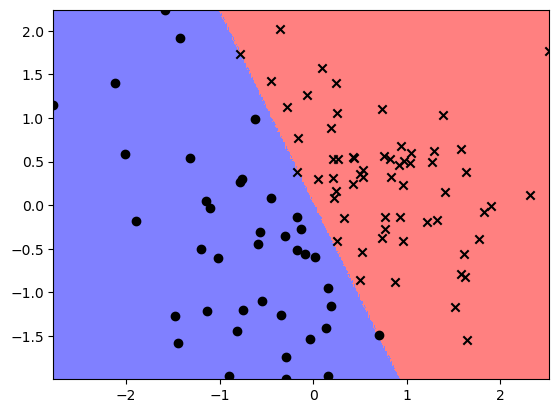

Training error: 2.0%


In [15]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,1000, C=100)
visclassifier.visclassifier(fun,xTr,yTr)
#err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
err=torch.mean((torch.sign(fun(xTr).flatten())!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [16]:
# Hidden Test 1: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if the signs of predictions are correct

In [17]:
# Hidden Test 2: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if points farther from the decision boundary have larger predictions.

<h3>Spiral data set</h3>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [18]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

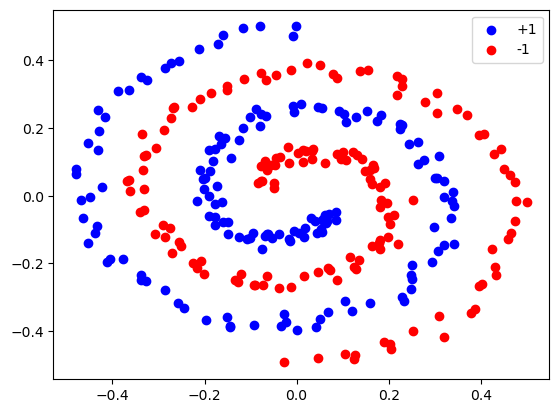

In [19]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

epoch 100 loss 15.325288772583008
epoch 200 loss 16.717124938964844
epoch 300 loss 4.152196884155273
epoch 400 loss 3.6736674308776855
epoch 500 loss 3.363675117492676
epoch 600 loss 16.931169509887695
epoch 700 loss 3.972867727279663
epoch 800 loss 16.07954216003418
epoch 900 loss 16.389892578125
epoch 1000 loss 3.904336929321289


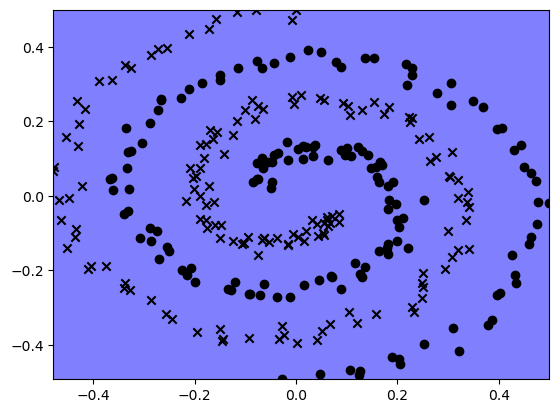

Training error: 50.0%


In [20]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kernel_type,X,Z,kpar)</pre>
It takes as input a kernel type <code>kernel_type</code> and two data sets $\mathbf{X} \in \mathcal{R}^{n\times d}$ and $\mathbf{Z} \in \mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>kernel_type='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>kernel_type='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed as the value of kpar)</li>
	<li>For the polynomial kernel (<code>kernel_type='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction, which is located in defined in one of your starter files l2distance.py.</p>

In [21]:
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # YOUR CODE HERE
    
    #print('computeK:', kernel_type, 'X:', X.shape, 'Z:', Z.shape, 'kpar:', kpar )

    n = X.shape[0]
    d = X.shape[1]
    m = Z.shape[0]
    
    K = torch.empty((n,m))
    
    # linear: k(x,z) = X.T@Z - but Z may have more/less rows than X
    if (kernel_type == 'linear'):
        #K = X @ Z
        K = X @ Z.T
        return K
    
    # poly: Z may have less rows - thus do X@Z.T not X.T@Z
    elif (kernel_type == 'poly' or kernel_type == 'polynomial'):        
        K = torch.pow(1 + X @ Z.T, kpar)
        return K
    # rbf
    elif (kernel_type == 'rbf'):        
        dist_x_z = l2distance(X, Z)
        exp_param = -kpar * (torch.pow(dist_x_z, 2))
        K = torch.exp(exp_param)
        return K
    else:
        return K

In [22]:
# Hidden Test 3: testCase_computeK_linear
# ---------------------------------------
# This tests whether the linear kernel is computed properly on an example dataset.

In [23]:
# Hidden Test 4: testCase_computeK_polynomial
# -------------------------------------------
# This tests whether the polynomial kernel is computed properly on an example dataset.

In [24]:
# Hidden Test 5: testCase_computeK_rbf
# ------------------------------------
# This tests whether the rbf kernel is computed properly on an example dataset.

<h3>My Tests on computeK</h3>

In [25]:
def my_poly_K(X, Y, c, p):
    """
        Compute the polynomial kernel between two matrices X and Y::
            K(x, y) = (<x, y> + c)^p
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            c - an coefficient to trade off high-order and low-order terms (scalar)
            p - the degree of the polynomial kernel

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    print('\nmy_poly_k')
    K = X @ Y.T
    K += c
    K **= p
    return K


X = torch.Tensor([[1,1], [2,2], [3, 3]])
Z = torch.Tensor([[1,1], [2,2], [3,3], [4,4]])


print('----\nX:\n', X, '\nZ:\n', Z,'\n----')

K = computeK("linear", X, Z, 100)
print('linear:\n',K)

K = computeK("poly", X, Z, 2)
print('poly:\n', K)

K = my_poly_K(X,Z,1,2)
print(K)

K = computeK("rbf", X, Z, 1)
print('rbf:\n', K)


----
X:
 tensor([[1., 1.],
        [2., 2.],
        [3., 3.]]) 
Z:
 tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.]]) 
----
linear:
 tensor([[ 2.,  4.,  6.,  8.],
        [ 4.,  8., 12., 16.],
        [ 6., 12., 18., 24.]])
poly:
 tensor([[  9.,  25.,  49.,  81.],
        [ 25.,  81., 169., 289.],
        [ 49., 169., 361., 625.]])

my_poly_k
tensor([[  9.,  25.,  49.,  81.],
        [ 25.,  81., 169., 289.],
        [ 49., 169., 361., 625.]])
rbf:
 tensor([[1.0000e+00, 1.3534e-01, 3.3546e-04, 1.5230e-08],
        [1.3534e-01, 1.0000e+00, 1.3534e-01, 3.3546e-04],
        [3.3546e-04, 1.3534e-01, 1.0000e+00, 1.3534e-01]])


<h3>Additional Testing</h3>
<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

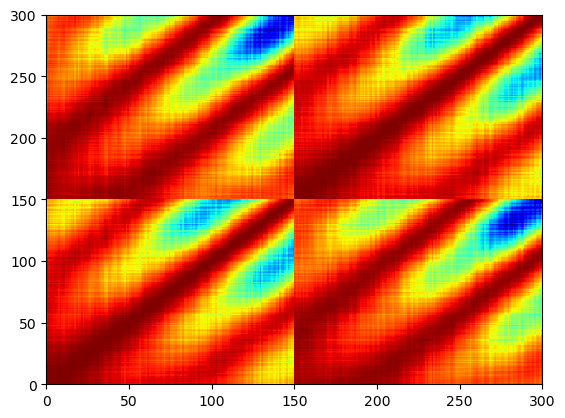

In [26]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation: (1)
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal (2)
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$. However, after a change of variable, with $\beta_i = \alpha_iy_i$ and $\beta \in R^n$, (2) can be rewritten as follows (see https://arxiv.org/pdf/1404.1066.pdf for details):
$$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
where $k_i$ is the kernel matrix row corresponding to the ith training example. Notice that there are two relaxations: 1. the $\beta_i$ are unconstrained, in contrast to $\alpha_i$ in (1), which must satisfy $0 \leq \alpha_i \leq C$; and 2. the squared hinge loss is used in place of the more common absolute hinge loss.


<p>
    Implement the module 
    <pre>
    KernelizedSVM(dim, kernel_type, kpar=0)
    </pre>
    This is a kernelized version of the SVM as defined above, which must maintain some kind of internal parameters for beta and b (hint: think what <code>dim</code> should be as a function of our training data) should be used for. Further, you are given <code>kernel_type</code> and <code>kpar</code>, which you should use in the creation of kernels by means of the method you wrote above <code>computeK</code>. For the forward pass of the kernelized SVM, recall that it is defined as $h(x) = w^\top \phi(x) + b$, where $w = \sum_{i=1}^n \beta_i\phi(x_i)$. The output of your forward pass should be the classification itself of input data x.
</p>

In [27]:
class KernelizedSVM(nn.Module):
    def __init__(self, dim, kernel_type, kpar=0):
        # YOUR CODE HERE
        super(KernelizedSVM, self).__init__()
        
        # variables that are update by the model
        #self.beta = nn.Parameter(torch.zeros(dim), requires_grad=True) # Beta is basically one alpha per data point      
        #self.b = nn.Parameter(torch.zeros(1), requires_grad=True)
        
        self.beta = nn.Parameter(torch.zeros(dim), requires_grad=True) # Beta is basically one alpha per data point      
        self.b = nn.Parameter(torch.zeros(1), requires_grad=True)
        
        self.kernel_type = kernel_type
        self.kpar = kpar
        
        # set at end
        self.w = None
    
    '''
    #
    # forward pass - called to classify - doesn't work
    #
    def forward(self, xTr, x):
        #w = (self.beta.T @ self.xTr).float()
        w = (self.beta.T @ xTr)
        pred = (w @ x.T)
        pred = pred + self.b
        pred = torch.sign(pred)
        return pred
    '''
    
    # all params to the function have a purpose.....
    # [Sigma(beta_i.phi_x_i)].T phi(x) +b
    # = Beta.phi(xTr).T.phi(x) + b
    # = Beta. phi(xTr)T.phi(x) +b ????
    # = Beta K + b??
    # K(X, x_i) = phi(X)phi(x_i_)
    def forward(self, xTr, x):

        K = computeK(self.kernel_type, xTr, x, self.kpar)
        
        # pred = beta.K + b??
        pred = (K.T @ self.beta) + self.b
        return torch.sign(pred)

<p>
    Implement the function 
    <pre>
    kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C)
    </pre>
    It should implement the loss function described above for the equivalent primal formulation of the dual:
    $$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
  You are given a KernalizedSVM module (<code>kernelizedSVM</code>) which you defined above, the kernel (<code>kernel_mat</code>), the training labels (<code>yTr</code>), and the regularizatin paramater (<code>C</code>). 
 
Note that this function <b>requires no loops</b>, and that you may find two functions especially helpful 
* <code>F.relu(x)</code> computes the <code>max(x,0)</code> in a way that allows for our optimizers to work (F is torch.nn.Functional, a library imported above) 
* <code>torch.square(x)</code> Returns a new tensor with the square of the elements of input.
</p>

In [28]:
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    # YOUR CODE HERE
    
    # yTr = labels for the x's we are training
    # kernel_mat = rows from Kernel Matrix for the x's we are testing (i.e. same as computeK(xTr,x) )
    pred    = yTr * ((kernel_mat @ kernelizedSVM.beta) + kernelizedSVM.b)

    z       = 1 - pred
    loss    = torch.square(F.relu(z))
    
    # strategy 1 (below) only works with mean (makes sense as passing a load of datapoints?)
    loss    = C * 0.5 * torch.mean(loss)
    
    return loss

<p>
    Implement the function 
    <pre>
    dualSVM(xTr, yTr, kernel_type, num_epochs, C, kpar, lr)
    </pre>
    It should use your functions <code><b>kernelsvm_loss</b></code>, <code><b>computeK</b></code>, and <code><b>KernelizedSVM</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>), to be used as kpar in Kernel construction. This will once again be a training loop similar to the primalSVM above. You should return a lambda function <code>svmclassify</code> that produces a forward pass of your trained model.
</p>

In [29]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=100, C=1, lmbda=0, lr=1e-3):
    # YOUR CODE HERE
    print_freq=100
    dim = yTr.shape[0]
    
    # setup
    svmclassify = KernelizedSVM(dim, kernel_type, lmbda)
    optimizer   = optim.SGD(svmclassify.parameters(), lr=lr)
    
    # compute K - only need to do once
    K = computeK(kernel_type, xTr, xTr, lmbda)

    # Strategy - TODO
    # 1. Just pass all items in one go and beta without yTr > 27/1 this seems to work but only if pass back mean loss
    # 2. As 1 but randomising on each epoch - (tried but randomising beta was not obvious in PyTorch, try again if 1.fails)
    # 3. Iterate through each x and calc individual hinge loss for SGD - also tried but need to revisit (worked for Primal)
    for epoch in range(num_epochs):
        # calculate loss for current item
        h_loss = kernelsvm_loss(svmclassify, K, yTr, C)
        
        # get reguariser
        K_beta = K @ svmclassify.beta
        regulariser = 0.5 * (svmclassify.beta @ K_beta )
        
        # compute overall loss
        loss = regulariser + h_loss 
            
        # backpropagate, optimise and zero the gradients
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
        
    svm_lmbda = lambda x: svmclassify(xTr, x)
    return svm_lmbda

<h3>Testing</h3>
<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

epoch 100 loss 20.57244873046875
epoch 200 loss 18.621065139770508
epoch 300 loss 18.32999038696289
epoch 400 loss 18.258066177368164
epoch 500 loss 18.228843688964844
epoch 600 loss 18.21182632446289
epoch 700 loss 18.199892044067383
epoch 800 loss 18.19080924987793
epoch 900 loss 18.183631896972656
epoch 1000 loss 18.17782974243164


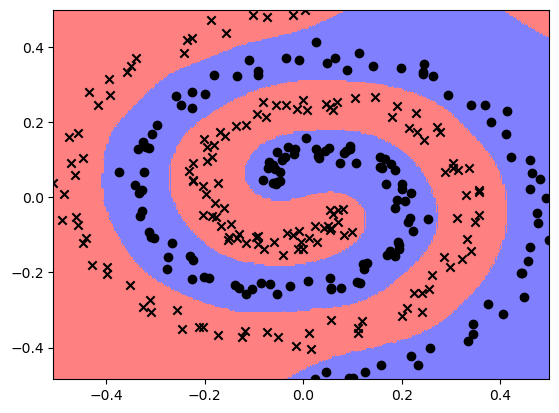

Training error: 0.0000
Testing error: 0.0000


In [30]:
xTr,yTr,xTe,yTe=spiraldata()

# poly kernel parameters that don't blow up vvv
# ktype="poly"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# linear kernel parameters that also don't blow up vvv
# ktype="linear"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# rbf kernel with parameters that achieve perfect accuracy vvv 
ktype="rbf"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=100, lmbda=100, lr=1e-3)
#svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=100, lmbda=100, lr=1e-3)

# I have commented this put in autograder
visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)

trainingerr=torch.mean((torch.sign(predsTr.flatten())!=yTr).float())
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=torch.mean((torch.sign(predsTe.flatten())!=yTe).float())
print("Testing error: %2.4f" % testingerr)


<h3>Testing Hint</h3> Create a dataset where you know what some of the optimal values of $\alpha$ will be, and test to make sure that the solution gets those values of $\alpha$ correct (recall from the lecture that the $\alpha$ values associated with certain data points are guaranteed to have a specific optimal value).

In [31]:
# Hidden Test 6: testCase_dualSVM_easy_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies an example dataset.

In [32]:
# Hidden Test 7: testCase_dualSVM_hard_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies a hard example dataset.

In [33]:
# Hidden Test 8: testCase_dualSVM_hard_dataset2
# ---------------------------------------------
# This tests whether the function from dualSVM correctly classifies an even harder example dataset.

SVMs are pretty sensitive to hyper-parameters. We ask you to implement a cross-validation function. <code>cross_validation</code> which takes training data <code>xTr</code>, training labels <code>yTr</code>, validation data <code>xValid</code>, validation labels <code>yValid</code>, kernel type <code>ktype</code>, list of possible C values <code>CList</code>, list of lambda values for kernel generation <code>lmbdaList</code>, and list of learning rates <code>lr_list</code>.

Note that we don't have <code>epochs</code> as a hyper-parameter to tune even, though the number of epochs we train on can vastly change the performance of our model. Generally we train with gradient descent <b>until convergence</b> (when train/validation loss stop decreasing); therefore, something you can do to get a good idea of what amount of epochs you need is plot [epoch number x (training,validation)] loss! <b>This convergence part will not be tested</b>, but is something that might help. 

In [34]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    # YOUR CODE HERE
    
    # setup params
    ErrorMatrix = torch.zeros((len(CList), len(lmbdaList), len(lr_List)))
    bestC, bestLmbda, bestLr = None, None, None
    bestTestingErr = np.inf
    
    NUM_EPOCHS = 100
    dbg = False

    start = time.time()
    
    for i, C in enumerate(CList):
        for j , lmbda in enumerate(lmbdaList):
            for k, lr in enumerate(lr_List):
                #print('Executing', i,j,k)
                svmclassify=dualSVM(xTr, yTr, ktype, NUM_EPOCHS, C, lmbda, lr)
                
                predsTe = svmclassify(xValid)
                testingerr = torch.mean((torch.sign(predsTe.flatten())!=yValid).float())
                ErrorMatrix[i,j,k] = testingerr
                
                if testingerr < bestTestingErr:
                    bestC = C
                    bestLmbda = lmbda
                    bestLr = lr
                    bestTestingErr = testingerr
                if(dbg): print(i,j,k, C, lmbda, lr, testingerr, ErrorMatrix[i,j,k], bestTestingErr)

    end = time.time()
    total_time = end - start

    print('Best C, Lambda, LR:', bestC, bestLmbda, bestLr, 'Error:', bestTestingErr, 'Epochs:', NUM_EPOCHS, 'Time (s):', total_time)
    
    return bestC,bestLmbda,bestLr,ErrorMatrix

<h3>Testing</h3>

In [35]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))
lrList=(np.linspace(0.001,0.005,5))

bestC,bestLmbda,bestLr,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList,lrList)

epoch 100 loss 0.24998438358306885
epoch 100 loss 0.2499719113111496
epoch 100 loss 0.24996191263198853
epoch 100 loss 0.24995391070842743
epoch 100 loss 0.24994753301143646
epoch 100 loss 0.24994806945323944
epoch 100 loss 0.24991446733474731
epoch 100 loss 0.24989260733127594
epoch 100 loss 0.24987845122814178
epoch 100 loss 0.2498691976070404
epoch 100 loss 0.2499018907546997
epoch 100 loss 0.24984967708587646
epoch 100 loss 0.24982179701328278
epoch 100 loss 0.24980688095092773
epoch 100 loss 0.24979884922504425
epoch 100 loss 0.24985210597515106
epoch 100 loss 0.2497866004705429
epoch 100 loss 0.24975743889808655
epoch 100 loss 0.24974441528320312
epoch 100 loss 0.24973857402801514
epoch 100 loss 0.24980226159095764
epoch 100 loss 0.24972856044769287
epoch 100 loss 0.24970091879367828
epoch 100 loss 0.2496904879808426
epoch 100 loss 0.24968650937080383
epoch 100 loss 0.4999375641345978
epoch 100 loss 0.49988770484924316
epoch 100 loss 0.4998479187488556
epoch 100 loss 0.4998161196

In [36]:
# Hidden Test 9: testCase_cv
# ---------------------------
# This tests whether the best hyperparameters found by cross validation are correct for an example dataset.

<h3>Competition</h3>


We ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get full credit for the competition if you can beat the base benchmark of <b>46% error</b> (you will get partial credit if you beat <b>50% error</b>).

In [37]:
# competition Dual SVM - May use different optimiser
# 1. Use a diff optimiser
# 2. Break out when loss stabilises?

def dualSVM_comp(xTr, yTr, kernel_type, num_epochs=100, C=1, lmbda=0, lr=1e-3):
    # YOUR CODE HERE
    print_freq=100
    dim = yTr.shape[0]
    
    # setup
    svmclassify = KernelizedSVM(dim, kernel_type, lmbda)
    #print('using SGD optimizer')
    optimizer   = optim.Adam(svmclassify.parameters(), lr=lr, amsgrad=False)
    
    # compute K - only need to do once
    K = computeK(kernel_type, xTr, xTr, lmbda)

    # epoch loop
    for epoch in range(num_epochs):
        # calculate loss for current item
        h_loss = kernelsvm_loss(svmclassify, K, yTr, C)
        
        # get reguariser
        K_beta = K @ svmclassify.beta
        regulariser = 0.5 * (svmclassify.beta @ K_beta )
        
        # compute overall loss
        loss = regulariser + h_loss 
            
        # backpropagate, optimise and zero the gradients
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #if (epoch + 1) % print_freq == 0:
        #    print('epoch {} loss {}'.format(epoch+1, loss.item()))
        
    svm_lmbda = lambda x: svmclassify(xTr, x)
    return svm_lmbda


#
# cross validation
#
def cross_validation_comp(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List, epochs):
    
    # YOUR CODE HERE
    i,j,k       = 0,0,0
    numCs       = len(CList)
    numLmbda    = len(lmbdaList)
    numLr       = len(lr_List)
    ErrorMatrix = torch.zeros((numCs,numLmbda,numLr))
    bestC, bestLmbda, bestLr = None, None, None
    bestTestingErr = np.inf
    dbg = False
    
    for C in CList:
        j=0
        for lmbda in lmbdaList:
            k=0
            for lr in lr_List:

                # create classifier and update best values
                svmclassify = dualSVM_comp(xTr, yTr, ktype, epochs, C, lmbda, lr)
                predsTe = svmclassify(xValid)
                testingerr = torch.mean((torch.sign(predsTe.flatten())!=yValid).float())
                ErrorMatrix[i,j,k] = testingerr
                
                if testingerr < bestTestingErr:
                    bestC = C
                    bestLmbda = lmbda
                    bestLr = lr
                    bestTestingErr = testingerr
                k+=1
            j+=1
        i+=1   
    #raise NotImplementedError()
    return bestC,bestLmbda,bestLr,ErrorMatrix


#
# Auto SVM
#
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    # YOUR CODE HERE
    start = time.time()
    
    NUM_EPOCHS = 200
    
    N = yTr.shape[0]
    train_percent = 0.8
    train_amount = int(N * train_percent)

    # split data set
    xTrain, yTrain = xTr[:train_amount], yTr[:train_amount]
    xValid, yValid = xTr[train_amount:], yTr[train_amount:]
    
    
    CList=(2.0**np.linspace(-1,5,7))
    lmbdaList=(np.linspace(0.1,0.5,5))
    lrList=(np.linspace(0.001,0.005,5))

    # get params from cross validation
    bestC,bestLmbda,bestLr,ErrorMatrix = cross_validation_comp(xTrain,yTrain,xValid,yValid,'rbf',CList,lmbdaList,lrList, NUM_EPOCHS)

    # create classifier
    svmclassify=dualSVM_comp(xTr, yTr, 'rbf', NUM_EPOCHS, bestC, bestLmbda, bestLr)
    
    end = time.time()
    total_time = end - start
    #print('Best C, Lambda, LR:', bestC, bestLmbda, bestLr, 'Epochs:', NUM_EPOCHS, 'Time:', total_time, 's')
    
    return svmclassify

In [38]:
# Hidden Test 11: competition
# ---------------------------
# This tests the error rate of your classifier on the competition datasets 
# (remember each cell in this notebook should run in < 5 minutes!)

In [39]:
# Prints out the summary of tests passed/failed.